# Feature engineering of the titanic data set

Data source: https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("../data/train.csv", index_col=0)

In [4]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Overview

<AxesSubplot:ylabel='PassengerId'>

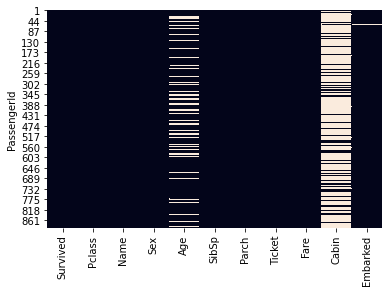

In [5]:
sns.heatmap(df.isna(), cbar = False)

In [6]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## Manually select columns/features and drop NaNs

In [7]:
df_original = pd.DataFrame(df) # keep (deep) copy of original Data

In [8]:
df['Survived'] = df['Survived'].map({0:'No', 1:'Yes'})

In [9]:
df.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

## Test split

Define X and y:
* X : Training data
* y : Target values

In [10]:
y = df['Survived']
X = df.drop(['Survived'], axis=1) # alternative df.loc[:,df.columns != 'Survived']

Split:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Transformations

Create a few ColumnTransformers and train them on the Titanic data. Here are a few ideas to work on:
* impute the missing values in the **Age** column
* one-hot-encode the **Embarked** column
* bin the imputed **Age** column into 3 bins (young, middle-aged, old)
* scale the **Fare** column

Sources:
* How to combine _Pipeline_ and _ColumnTransformer_: https://youtu.be/HK9keM3lre4?t=395
* How to access Numpy arrays: https://numpy.org/doc/stable/reference/arrays.indexing.html

In [12]:
preprocessor = make_column_transformer(
     [ SimpleImputer(missing_values=np.nan, strategy='mean') , ['Age'] ]
    ,[ OneHotEncoder(), ['Sex'] ]
    ,[ make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder()) , ['Embarked'] ]
    ,[ make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),KBinsDiscretizer(n_bins=3)) , ['Age'] ]
    ,[ StandardScaler() , ['Fare'] ]
    #,remainder='passthrough'
)

In [13]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('simpleimputer', SimpleImputer(), ['Age']),
                                ('onehotencoder', OneHotEncoder(), ['Sex']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['Embarked']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('kbinsdiscretizer',
                                                  KBinsDiscretizer(n_bins=3))]),
                                 ['Age']),
                                ('standardscaler', StandardScaler(), ['Fare'])]

In [14]:
X_test_tf = preprocessor.transform(X_test)
X_train_tf = preprocessor.transform(X_train)

## Modelling

In [15]:
model = LogisticRegression(max_iter=1000)

In [16]:
model.fit(X_train_tf, y_train)

LogisticRegression(max_iter=1000)

## Evaluation

In [17]:
y_pred = model.predict(X_test_tf)

In [18]:
accuracy_score(y_pred, y_test)

0.7757847533632287

--------------------
## Misc / Notes

<AxesSubplot:>

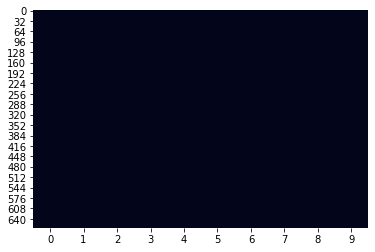

In [19]:
sns.heatmap(pd.DataFrame(X_train_tf).isna(), cbar = False)

In [20]:
np.count_nonzero(np.isnan(X_train_tf))

0

## Train a logistic regression model

TODO
* try using `ColumnTransformer` instead of `make_column_transformer` to have column names afterwards ?
* (creative improvements)